In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import numpy as np
from scipy import stats

plt.rcParams.update({'font.size': 16})

### Read inputs and process

In [2]:
benzene_quints = []
free_quints = []
bound_quints = []

# quintuplicates provided by Cresset. FEP+/JACS set.
with open("compiled_mbar_freenrgs_cresset_jacs.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        if "free" in row[0]:
            free_quints.append(row)
        elif "bound" in row[0]:
            bound_quints.append(row)

# quintuplicates run in-house. Merck set.
with open("compiled_mbar_freenrgs_jscheen_merck.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:

        if "free" in row[0]:
            free_quints.append(row)
        elif "bound" in row[0]:
            bound_quints.append(row)
            
# quintuplicates run in-house. FEP-space set. Should match the perturbations in the above two files.
with open("compiled_mbar_freenrgs_fepspace.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:

        benzene_quints.append([row[0].replace("lig_", ""), row[-1]])


In [3]:
def computeDDGSems(free, bound):
    """For a series of perturbations with dG predictions in free and bound phase, return the quintuplicate SEM."""
    perts, tgts, ddg_sems = [], [], []
    for free_pert in free:
        bound_pert_query = free_pert[0].replace("_free", "_bound")
        for bound_pert in bound:
            if bound_pert[0] == bound_pert_query:
                
                freenrgs_free = free_pert[1:6]
                freenrgs_bound = bound_pert[1:6]
                ddGs = np.array(freenrgs_free, dtype=float) - np.array(freenrgs_bound, dtype=float)
                ddg_sem = stats.sem(ddGs)
                
                perts.append("_".join(free_pert[0].split("_")[:-2]))
                tgts.append(free_pert[0].split("_")[-2])
                ddg_sems.append(ddg_sem)   
                
    return perts, tgts, ddg_sems

In [4]:
def returnInfo(input_list):
    """given a nested list, return the perturbations, targets and SEMs as arrays."""
    
    pert_names = []
    targets = []
    sems = []
    
    for row in input_list:
        # just some convoluted conditionals to deal with inconsistent ligand naming.
        if len(row[0].split("_")) >= 3:
            pert_name = "_".join(row[0].split("_")[:-2])
        else:
            pert_name = row[0].split("_")[0]
            
        if "free" in row[0] or "bound" in row[0]:    
            target = row[0].split("_")[-2].replace("mcl", "mcl1")
        else:
            target = row[0].split("_")[-1].replace("mcl", "mcl1")

        sem = float(row[-1])
        
        pert_names.append(pert_name)
        targets.append(target)
        sems.append(sem)
        
    return pert_names, targets, sems

In [5]:
perts_benz, tgts_benz, sems_benz = returnInfo(benzene_quints)

perts_b, tgts_b, sems_b = returnInfo(free_quints)
perts_free, tgts_free, sems_free = returnInfo(bound_quints)

perts_ddg, tgts_ddg, sems_ddg = computeDDGSems(free_quints, bound_quints)

In [6]:
benz_df = pd.DataFrame.from_dict({"pert" : perts_benz,
                          "tgt" : tgts_benz,
                          "sem_benz" : sems_benz
                                 })

b_df = pd.DataFrame.from_dict({"pert" : perts_b,
                          "tgt" : tgts_b,
                          "sem_b" : sems_b
                              })

free_df = pd.DataFrame.from_dict({"pert" : perts_free,
                          "tgt" : tgts_free,
                          "sem_free" : sems_free
                                 })

ddg_df = pd.DataFrame.from_dict({"pert" : perts_ddg,
                          "tgt" : tgts_ddg,
                          "sem_ddg" : sems_ddg
                                 })

In [7]:
two_df = pd.merge(benz_df, b_df, how='left', on=['pert', 'tgt'])
three_df = pd.merge(two_df, free_df, how='left', on=['pert', 'tgt']).dropna()
full_df = pd.merge(three_df, ddg_df, how='left', on=['pert', 'tgt']).dropna()

## Plot 

Total number of perturbations: 231


/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an

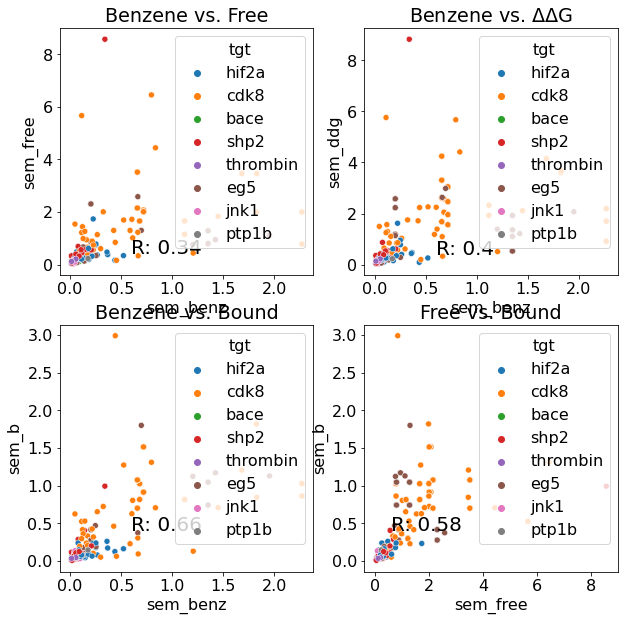

In [8]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

print("Total number of perturbations:", len(full_df["sem_benz"]))
#######

sns.scatterplot("sem_benz", "sem_free", data=full_df, hue="tgt", ax=axes[0][0])
axes[0][0].set_title("Benzene vs. Free")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_free"])
axes[0][0].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)


#######
sns.scatterplot("sem_benz", "sem_b", data=full_df, hue="tgt", ax=axes[1][0])
axes[1][0].set_title("Benzene vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_b"])
axes[1][0].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)

#######
sns.scatterplot("sem_free", "sem_b", data=full_df, hue="tgt", ax=axes[1][1])
axes[1][1].set_title("Free vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_free"], full_df["sem_b"])
axes[1][1].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)

#######
sns.scatterplot("sem_benz", "sem_ddg", data=full_df, hue="tgt", ax=axes[0][1])
axes[0][1].set_title("Benzene vs. $\Delta\Delta$G")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_ddg"])
axes[0][1].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)
#######


# for ax in axes:
# #     ax.set_ylim(0, 1)
# #     ax.set_xlim(0, 1)
#     ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")
    
# axes[0].set_ylabel("Free SEM / kcal$\cdot$mol$^{-1}$")
# axes[1].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")
# axes[2].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")

# axes[0].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
# axes[1].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
# axes[2].set_xlabel("Free SEM / kcal$\cdot$mol$^{-1}$")
# axes[0].legend([],[], frameon=False)
# axes[1].legend([],[], frameon=False)
plt.show()

## Repeat but exclude SEM > 0.5 kcal/mol

Total number of perturbations: 95
Total number of perturbations: 95


/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an

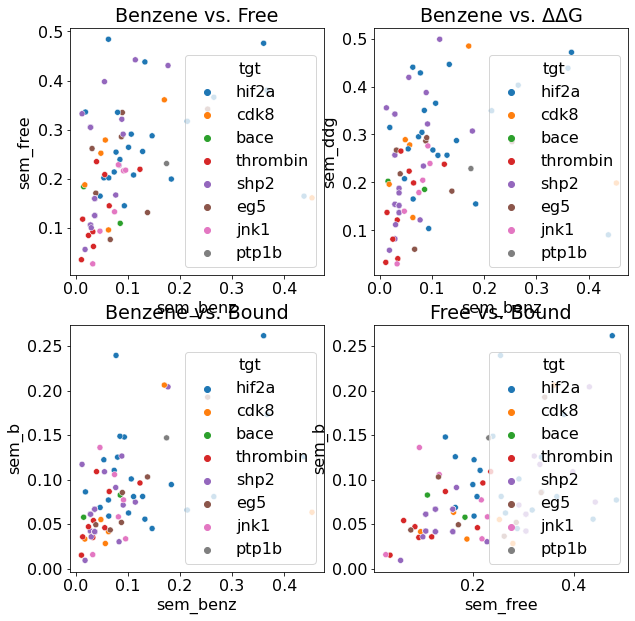

In [9]:
excluded_df = full_df[full_df["sem_benz"] < 0.5]
excluded_df = excluded_df[excluded_df["sem_b"] < 0.5]
excluded_df = excluded_df[excluded_df["sem_free"] < 0.5]

print("Total number of perturbations:", len(excluded_df["sem_benz"]))
fig, axes = plt.subplots(2,2, figsize=(10,10))

print("Total number of perturbations:", len(excluded_df["sem_benz"]))
#######

sns.scatterplot("sem_benz", "sem_free", data=excluded_df, hue="tgt", ax=axes[0][0])
axes[0][0].set_title("Benzene vs. Free")

_, _, r_value, _, _ = stats.linregress(excluded_df["sem_benz"], excluded_df["sem_free"])
axes[0][0].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)


#######
sns.scatterplot("sem_benz", "sem_b", data=excluded_df, hue="tgt", ax=axes[1][0])
axes[1][0].set_title("Benzene vs. Bound")

_, _, r_value, _, _ = stats.linregress(excluded_df["sem_benz"], excluded_df["sem_b"])
axes[1][0].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)

#######
sns.scatterplot("sem_free", "sem_b", data=excluded_df, hue="tgt", ax=axes[1][1])
axes[1][1].set_title("Free vs. Bound")

_, _, r_value, _, _ = stats.linregress(excluded_df["sem_free"], excluded_df["sem_b"])
axes[1][1].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)

#######
sns.scatterplot("sem_benz", "sem_ddg", data=excluded_df, hue="tgt", ax=axes[0][1])
axes[0][1].set_title("Benzene vs. $\Delta\Delta$G")

_, _, r_value, _, _ = stats.linregress(excluded_df["sem_benz"], excluded_df["sem_ddg"])
axes[0][1].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)
#######


# for ax in axes:
# #     ax.set_ylim(0, 1)
# #     ax.set_xlim(0, 1)
#     ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")
    
# axes[0].set_ylabel("Free SEM / kcal$\cdot$mol$^{-1}$")
# axes[1].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")
# axes[2].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")

# axes[0].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
# axes[1].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
# axes[2].set_xlabel("Free SEM / kcal$\cdot$mol$^{-1}$")
# axes[0].legend([],[], frameon=False)
# axes[1].legend([],[], frameon=False)
plt.show()

# Now colour by num_ha_perturbed

In [10]:
num_ha_array = []
for idx, line in full_df[["pert", "tgt"]].iterrows():
    added = False
    with open("./fepspace_perts.csv", "r") as fepspace_info:
        reader = csv.reader(fepspace_info)
        for row in reader:
            if row[0] == line["pert"] and row[1] == line["tgt"]:
                num_ha_array.append(int(row[2]))
                added = True
                
                
    if not added:
        with open("./fepspace_perts.csv", "r") as fepspace_info:           
            reader = csv.reader(fepspace_info)
            next(reader)
            for row in reader:
                new_pert_name = "lig_"+row[0].split("~")[0]+"~lig_"+row[0].split("~")[1]

                if new_pert_name == line["pert"] and row[1] == line["tgt"]:
                    num_ha_array.append(int(row[2]))
                    added = True
    if not added:
        full_df.drop(idx, inplace=True)
            

In [11]:
full_df["num_ha_perturbed"] = num_ha_array

In [12]:
import matplotlib as mpl

In [13]:
full_df.sort_values(by="num_ha_perturbed").tail(1)

,pert,tgt,sem_benz,sem_b,sem_free,sem_ddg,num_ha_perturbed
26,CHEMBL1078774~CHEMBL1093088,eg5,1.201159,1.123926,0.761543,1.39373,10


In [14]:
full_df_ori = full_df.copy()

## Log transform SEM values to account for noise

In [15]:
for col in ["sem_benz", "sem_b", "sem_free", "sem_ddg"]:
    full_df[col] = np.log(full_df[col])

In [16]:
full_df

,pert,tgt,sem_benz,sem_b,sem_free,sem_ddg,num_ha_perturbed
0,41~54,hif2a,-1.919002,-3.096880,-1.246891,-1.247261,4
1,30~38,cdk8,-2.761563,-3.179512,-2.346395,-2.064765,2
3,out17~out8,shp2,-1.078620,-0.005821,2.148724,2.177928,6
4,36~20,cdk8,-0.386244,0.026660,0.504983,0.946332,8
5,36~20,cdk8,-0.386244,0.026660,0.504983,0.718768,8
...,...,...,...,...,...,...,...
224,32~30,cdk8,0.113530,-0.203180,0.140847,0.844162,7
225,32~30,cdk8,0.113530,-0.203180,0.507187,0.659062,7
226,32~30,cdk8,0.113530,-0.203180,0.507187,0.844162,7
227,6~out23,shp2,-2.422246,-2.066618,-1.135850,-0.948273,3


Total number of perturbations: 213


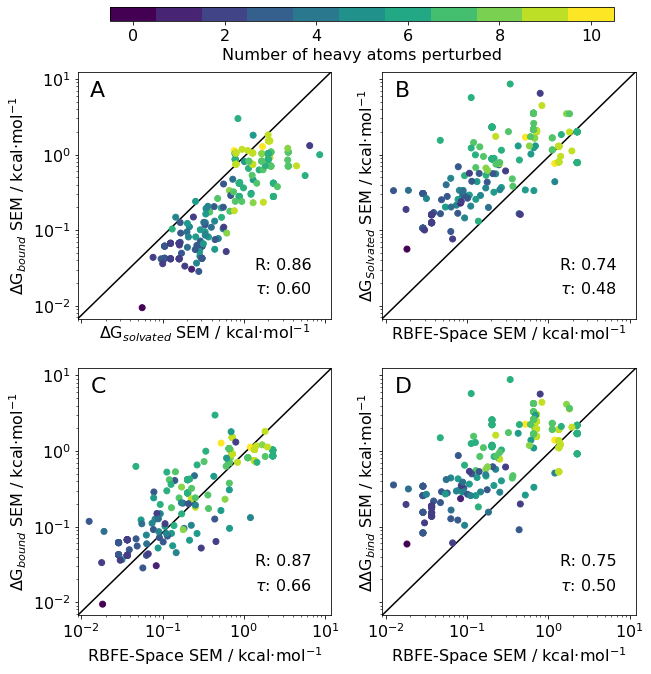

In [17]:
fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
print("Total number of perturbations:", len(full_df["sem_benz"]))
#######


#######
axes[0][0].scatter(full_df_ori["sem_free"], full_df_ori["sem_b"], c=full_df["num_ha_perturbed"])
#axes[0][0].set_title("Free vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_free"], full_df["sem_b"])
tau, _ = stats.kendalltau(full_df["sem_free"], full_df["sem_b"])
axes[0][0].annotate(text="R: "+'{:.2f}'.format(round(r_value, 2)), xy=(0.7, 0.2), xycoords="axes fraction")
axes[0][0].annotate(text=r"$\tau$: "+'{:.2f}'.format(round(tau, 2)), xy=(0.7, 0.1), xycoords="axes fraction")


axes[0][0].set_ylabel("$\Delta$G$_{bound}$ SEM / kcal$\cdot$mol$^{-1}$")
axes[0][0].set_xlabel("$\Delta$G$_{solvated}$ SEM / kcal$\cdot$mol$^{-1}$")





#######

axes[1][0].scatter(full_df_ori["sem_benz"], full_df_ori["sem_b"], c=full_df["num_ha_perturbed"])

#axes[1][0].set_title("Benzene vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_b"])
tau, _ = stats.kendalltau(full_df["sem_benz"], full_df["sem_b"])
axes[1][0].annotate(text="R: "+'{:.2f}'.format(round(r_value, 2)), xy=(0.7, 0.2), xycoords="axes fraction")
axes[1][0].annotate(text=r"$\tau$: "+'{:.2f}'.format(round(tau, 2)), xy=(0.7, 0.1), xycoords="axes fraction")


axes[1][0].set_xlabel("RBFE-Space SEM / kcal$\cdot$mol$^{-1}$")
axes[1][0].set_ylabel("$\Delta$G$_{bound}$ SEM / kcal$\cdot$mol$^{-1}$")


#######
axes[0][1].scatter(full_df_ori["sem_benz"], full_df_ori["sem_free"], c=full_df["num_ha_perturbed"])
#axes[0][1].set_title("Benzene vs. Free")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_free"])
tau, _ = stats.kendalltau(full_df["sem_benz"], full_df["sem_free"])
axes[0][1].annotate(text="R: "+'{:.2f}'.format(round(r_value, 2)), xy=(0.7, 0.2), xycoords="axes fraction")
axes[0][1].annotate(text=r"$\tau$: "+'{:.2f}'.format(round(tau, 2)), xy=(0.7, 0.1), xycoords="axes fraction")


axes[0][1].set_xlabel("RBFE-Space SEM / kcal$\cdot$mol$^{-1}$")
axes[0][1].set_ylabel("$\Delta$G$_{Solvated}$ SEM / kcal$\cdot$mol$^{-1}$")



#######
axes[1][1].scatter(full_df_ori["sem_benz"], full_df_ori["sem_ddg"], c=full_df["num_ha_perturbed"])
#axes[1][1].set_title("Benzene vs. $\Delta\Delta$G")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_ddg"])
tau, _ = stats.kendalltau(full_df["sem_benz"], full_df["sem_ddg"])
axes[1][1].annotate(text="R: "+'{:.2f}'.format(round(r_value, 2)), xy=(0.7, 0.2), xycoords="axes fraction")
axes[1][1].annotate(text=r"$\tau$: "+'{:.2f}'.format(round(tau, 2)), xy=(0.7, 0.1), xycoords="axes fraction")


axes[1][1].set_xlabel("RBFE-Space SEM / kcal$\cdot$mol$^{-1}$")
axes[1][1].set_ylabel("$\Delta\Delta$G$_{bind}$ SEM / kcal$\cdot$mol$^{-1}$")



#######
indexing = ["A", "B", "C", "D"]
for i, ax in enumerate(axes.flatten()):

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", zorder=-100)
    ax.annotate(indexing[i], xy=(0.05, 0.9), size=22, xycoords="axes fraction")
    ax.set_xscale('log')
    ax.set_yscale('log')




ax = fig.add_axes([0.17, 0.95, 0.7, 0.02])

cb = mpl.colorbar.ColorbarBase(ax, values=np.arange(0,11), label="Number of heavy atoms perturbed",
                              orientation='horizontal')
#plt.tight_layout()
plt.savefig("/home/jscheen/projects/FEPSPACE/figures/fepspace_vs_solvated_vs_bound_vs_ddg.png", dpi=300)

plt.show()